In [1]:
from __future__ import division
import os
import numpy as np
import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
import pickle, csv
import sys
import time
import datetime
import pandas as pd
#import nilearn
import nibabel as nib
from scipy.ndimage.morphology import binary_dilation
sys.path.append('..')
from utils import *
from model import UNet3D
#
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Project dir
proj_dir = '/Users/nikhil/code/git_repos/skull_seg/'

# Model training

In [3]:
# FLAGS
flags = tf.app.flags
flags.DEFINE_integer("epoch", 2, "Epoch to train [4]")
flags.DEFINE_string("train_patch_dir", proj_dir + "sample_data/patches/train/p32/", "Directory of the training data [patches]")
flags.DEFINE_bool("split_train", False, "Whether to split the train data into train and val [False]")
flags.DEFINE_string("train_data_dir", proj_dir + "sample_data/input/train/", "Directory of the train data [../BraTS17TrainingData]")
flags.DEFINE_string("deploy_data_dir", proj_dir + "sample_data/input/test/", "Directory of the test data [../BraTS17ValidationData]")
flags.DEFINE_string("deploy_output_dir", proj_dir + "sample_data/predictions/", "Directory name of the output data [output]")
# flags.DEFINE_string("train_csv", "../BraTS17TrainingData/survival_data.csv", "CSV path of the training data")
# flags.DEFINE_string("deploy_csv", "../BraTS17ValidationData/survival_evaluation.csv", "CSV path of the validation data")
flags.DEFINE_integer("batch_size", 10, "Batch size [1]")
flags.DEFINE_integer("seg_features_root", 64, "Number of features in the first filter in the seg net [48]")
flags.DEFINE_integer("conv_size", 3, "Convolution kernel size in encoding and decoding paths [3]")
flags.DEFINE_integer("layers", 2, "Encoding and deconding layers [3]")
flags.DEFINE_string("loss_type", "dice", "Loss type in the model [cross_entropy]")
flags.DEFINE_float("dropout", 0.5, "Drop out ratio [0.5]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("log_dir", "logs", "Directory name to save logs [logs]")
flags.DEFINE_boolean("train", True, "True for training, False for deploying [False]")
flags.DEFINE_boolean("run_seg", True, "True if run segmentation [True]")
flags.DEFINE_boolean("run_survival", False, "True if run survival prediction [True]")

flags.DEFINE_string('f', '', 'kernel') # Needed for jupyter to work 
FLAGS = flags.FLAGS #flags.FLAGS

In [4]:
# pp = pprint.PrettyPrinter()
# pp.pprint(flags.FLAGS.__flags)

# Train
# all_train_paths = []
# subject_dirs = next(os.walk(FLAGS.train_data_dir))[1]
# for d in subject_dirs: 
#     all_train_paths.append(os.path.join(FLAGS.train_data_dir,d))

test_patch_dir = proj_dir + "sample_data/patches/test/p32/"

training_paths = [os.path.join(FLAGS.train_patch_dir, name) for name in os.listdir(FLAGS.train_patch_dir)
                  if '.DS' not in name]
testing_paths = [os.path.join(test_patch_dir, name) for name in os.listdir(test_patch_dir)
                  if '.DS' not in name]

training_ids = [os.path.basename(i) for i in training_paths]
training_survival_paths = []
testing_survival_paths = None
training_survival_data = {}
testing_survival_data = None

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)

if not os.path.exists(FLAGS.log_dir):
    os.makedirs(FLAGS.log_dir)

In [5]:
# training bookkeeping
trained_model_stats = pd.DataFrame(columns=['run_index','net_structure','training_params',
                                            'stage','acc','dice','loss'])
run_index = 'UNET_1'
input_size = 32
net_structure = '{}_{}_{}'.format(input_size,FLAGS.layers,FLAGS.seg_features_root)
training_params = '{}_{}_{}'.format(FLAGS.epoch,FLAGS.loss_type,FLAGS.batch_size)

train_network = True
test_network = False

start_time = datetime.datetime.now()
print(start_time)

if FLAGS.run_seg:
    run_config = tf.ConfigProto()
    with tf.Session(config=run_config) as sess:
        unet = UNet3D(sess, checkpoint_dir=FLAGS.checkpoint_dir, log_dir=FLAGS.log_dir, training_paths=training_paths,
                      testing_paths=testing_paths, batch_size=FLAGS.batch_size, layers=FLAGS.layers,
                      features_root=FLAGS.seg_features_root, conv_size=FLAGS.conv_size,
                      dropout=FLAGS.dropout, loss_type=FLAGS.loss_type)

        if train_network:
            model_vars = tf.trainable_variables()
            slim.model_analyzer.analyze_vars(model_vars, print_info=True)

            train_config = {}
            train_config['epoch'] = FLAGS.epoch

            train_metrics,test_metrics = unet.train(train_config)
            
            #Save the perfromance at the end of training
            train_end_acc = train_metrics['acc'][-1]
            train_end_dice = train_metrics['dice'][-1]
            train_end_loss = train_metrics['loss'][-1]
            test_end_acc = test_metrics['acc'][-1]
            test_end_dice = test_metrics['dice'][-1]
            test_end_loss = test_metrics['loss'][-1]
            
            trained_model_stats.loc[0] = [run_index, net_structure, training_params, 'train', 
                                          train_end_acc, train_end_dice, train_end_loss]
            trained_model_stats.loc[1] = [run_index, net_structure, training_params, 'test',
                                          test_end_acc, test_end_dice, test_end_loss]
            
        print('Training complete')
        
        if test_network:
            print('\nTesting trained model with actual MR image')
            if not os.path.exists(FLAGS.deploy_output_dir):
                os.makedirs(FLAGS.deploy_output_dir)

            unet.deploy(FLAGS.deploy_data_dir, FLAGS.deploy_output_dir)
            print('Test complete. Output at {}'.format(FLAGS.deploy_output_dir))
        
    tf.reset_default_graph()

end_time = datetime.datetime.now()
print('start: {}, end: {}'.format(start_time, end_time))

2018-11-14 14:50:14.678857
encoding...
decoding...
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

---------
Variables: name (type shape) [size]
---------
encoding0/w1:0 (float32_ref 3x3x3x1x64) [1728, bytes: 6912]
encoding0/b1:0 (float32_ref 64) [64, bytes: 256]
encoding0/batch_normalization/gamma:0 (float32_ref 64) [64, bytes: 256]
encoding0/batch_normalization/beta:0 (float32_ref 64) [64, bytes: 256]
encoding0/w2:0 (float32_ref 3x3x3x64x64) [110592, bytes: 442368]
encoding0/b2:0 (float32_ref 64) [64, bytes: 256]
encoding0/batch_normalization_1/gamma:0 (float32_ref 64) [64, bytes: 256]
encoding0/batch_normalization_1/beta:0 (float32_ref 64) [64, bytes: 256]
encoding1/w1:0 (float32_ref 3x3x3x64x128) [221184, bytes: 884736]
encoding1/b1:0 (float32_ref 128) [128, bytes: 512]
encoding1/batch_normalization/gamma:0 (float32_ref 128) [128, bytes: 512

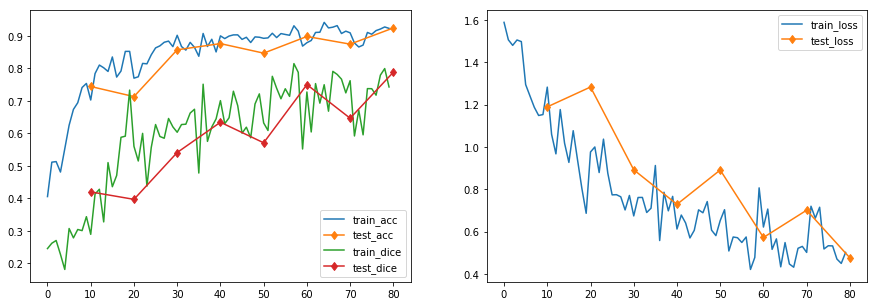

In [6]:
# Simple plots (tensorboard alternative)

train_acc = np.array(train_metrics['acc'])
train_dice = np.array(train_metrics['dice'])
train_loss = np.array(train_metrics['loss'])
test_acc = np.array(test_metrics['acc'])
test_dice = np.array(test_metrics['dice'])
test_loss = np.array(test_metrics['loss'])

test_interval = 10
steps = range(test_interval,len(train_acc)+test_interval,test_interval)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_acc,label='train_acc')
plt.plot(steps,test_acc,'-d',label='test_acc')

plt.plot(train_dice,label='train_dice')
plt.plot(steps,test_dice,'-d',label='test_dice')

plt.legend()
plt.subplot(1,2,2)
plt.plot(train_loss,label='train_loss')
plt.plot(steps,test_loss,'-d',label='test_loss')
plt.legend()

In [7]:
trained_model_stats

,run_index,net_structure,training_params,stage,acc,dice,loss
0,UNET_1,32_1_32,1_dice_10,train,0.894873,0.779638,0.604426
1,UNET_1,32_1_32,1_dice_10,test,0.914304,0.719764,0.632419
